# create Pseudobulk summarized experiment deg analysis for Longitudinal study
## AIFI l2 deep clean data - all 3 aims

In [1]:
# load library
quiet_library <- function(...) {
    suppressPackageStartupMessages(library(...))
}
quiet_library(Seurat)
quiet_library(tidyverse)
quiet_library(ggplot2)
quiet_library(Matrix)
quiet_library(dplyr)
quiet_library(viridis)
quiet_library('MAST')
quiet_library('scran')
quiet_library('data.table')
quiet_library('SingleCellExperiment')
quiet_library('SeuratDisk')
quiet_library('tictoc')
quiet_library('glmmSeq')
quiet_library('DESeq2')
quiet_library('knitr')
quiet_library('kableExtra')
quiet_library('SummarizedExperiment')

Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘scran’ was built under R version 4.3.3”
Warning message:
“package ‘DESeq2’ was built under R version 4.3.3”


In [2]:
packageVersion('SeuratDisk')
set.seed(1234)

[1] ‘0.0.0.9021’

In [3]:
# define working path
data_path = '/home/jupyter/data/immune_health/scRNA/counts'
fig_path = '/home/jupyter/data/immune_health/figures'
meta_path = '/home/jupyter/github/ra-longitudinal/metadata'
output_path = '/home/jupyter/data/immune_health/output_results'
proj_name = 'BRI_scRNA_AIFI_L2_Pseudobulk_'

In [4]:
# define the color palette to be used
npg_color <- c("#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", 
               "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF")
nejm_color <- c("#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF", "#7876B1FF", "#6F99ADFF", "#FFDC91FF", "#EE4C97FF")
jama_color <- c("#374E55FF", "#DF8F44FF", "#00A1D5FF", "#B24745FF", "#79AF97FF", "#6A6599FF", "#80796BFF")
jco_color <- c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF", "#8F7700FF")
cluster_colors <- c("#DC050C", "#FB8072", "#1965B0", "#7BAFDE", "#882E72", "#B17BA6", "#FF7F00", "#FDB462", "#E7298A", 
    "#E78AC3", "#33A02C", "#B2DF8A", "#55A1B1", "#8DD3C7", "#A6761D", "#E6AB02", "#7570B3", "#BEAED4", "#666666", "#999999", 
    "#aa8282", "#d4b7b7", "#8600bf", "#ba5ce3", "#808000", "#aeae5c", "#1e90ff", "#00bfff", "#56ff0d", "#ffff00")
cluster_colors_ext <- colorRampPalette(cluster_colors)(36)
options(repr.plot.width = 20, repr.plot.height = 15)

## load psedocounts and metadata in each aim and cell types

In [5]:
# convert anndata into sce
counts_files <- list.files(pattern = '*psbulk_counts.tsv', data_path, recursive = TRUE)
meta_files <- list.files(pattern = '*psbulk_metadata.csv', data_path, recursive = TRUE)
# double check the cell type matches
cell_types = counts_files%>%str_remove('BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__')%>%
    str_remove('_psbulk_counts.tsv')
cell_type2 = meta_files%>%str_remove('BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__')%>%
    str_remove('_psbulk_metadata.csv')
all(cell_types==cell_type2)
# create a table to point to all data
files_tb_bri <- tibble('cell_type' = cell_types,
                   'counts_file'=counts_files, 'meta_file'=meta_files,
                      'cohort' = 'BRI', status='health')
files_tb_bri%>%head()

[1] TRUE

cell_type,counts_file,meta_file,cohort,status
<chr>,<chr>,<chr>,<chr>,<chr>
ASDC,BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__ASDC_psbulk_counts.tsv,BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__ASDC_psbulk_metadata.csv,BRI,health
CD14 monocyte,BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__CD14 monocyte_psbulk_counts.tsv,BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__CD14 monocyte_psbulk_metadata.csv,BRI,health
CD16 monocyte,BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__CD16 monocyte_psbulk_counts.tsv,BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__CD16 monocyte_psbulk_metadata.csv,BRI,health
CD56bright NK cell,BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__CD56bright NK cell_psbulk_counts.tsv,BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__CD56bright NK cell_psbulk_metadata.csv,BRI,health
CD56dim NK cell,BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__CD56dim NK cell_psbulk_counts.tsv,BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__CD56dim NK cell_psbulk_metadata.csv,BRI,health
CD8aa,BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__CD8aa_psbulk_counts.tsv,BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__CD8aa_psbulk_metadata.csv,BRI,health


In [29]:
# load data for one cell type
pb_counts <- fread(file.path(data_path, files_tb_bri$counts_file[1]))%>% rename('V1'='index')
# load the metadata
pb_meta <- fread(file.path(data_path, files_tb_bri$meta_file[1]))%>% rename('V1'='index')
# check the index 
stopifnot(all(pb_counts$index==pb_meta$index))
# make count matrix
pb_counts_mx <- pb_counts %>% select(-index)%>%
    as.data.frame()%>% t()
# make summarized experiment
pb_se <- SummarizedExperiment(assays=list(counts=pb_counts_mx), colData=pb_meta)
pb_se

class: SummarizedExperiment 
dim: 2410 3 
metadata(0):
assays(1): counts
rownames(2410): AASDHPPT AATF ... ZSWIM7 ZYX
rowData names(0):
colnames: NULL
colData names(28): index sample.sampleKitGuid ... lib_size log_lib_size

In [30]:
pb_meta%>%colnames()

[1] "index"                      "sample.sampleKitGuid"      
 [3] "AIFI_L2"                    "batch_id"                  
 [5] "pool_id"                    "AIFI_L1"                   
 [7] "cohort.cohortGuid"          "subject.subjectGuid"       
 [9] "subject.biologicalSex"      "subject.cmv"               
[11] "subject.race"               "subject.ethnicity"         
[13] "subject.birthYear"          "subject.ageAtFirstDraw"    
[15] "sample.visitName"           "sample.drawDate"           
[17] "sample.subjectAgeAtDraw"    "specimen.specimenGuid"     
[19] "pipeline.fileGuid"          "age"                       
[21] "BMI"                        "sample.daysSinceFirstVisit"
[23] "days_since_first"           "file.batchID"              
[25] "psbulk_n_cells"             "psbulk_counts"             
[27] "lib_size"                   "log_lib_size"

In [9]:
# loop for all cell type in BRI longitudinal data
pb_se <- lapply(1:nrow(files_tb_bri), function(x){
    # load data for one cell type
    pb_counts <- fread(file.path(data_path, files_tb_bri$counts_file[x]))%>% rename('V1'='index')
    # load the metadata
    pb_meta <- fread(file.path(data_path, files_tb_bri$meta_file[x]))%>% rename('V1'='index')
    # check the index 
    stopifnot(all(pb_counts$index==pb_meta$index))
    # make count matrix
    pb_counts_mx <- pb_counts %>% select(-index)%>%
        as.data.frame()%>% t()
    # make summarized experiment
    pb_se <- SummarizedExperiment(assays=list(counts=pb_counts_mx), colData=pb_meta)
})
names(pb_se) <- files_tb_bri$cell_type

In [10]:
pb_se%>%length()
proj_name

[1] 29

[1] "BRI_scRNA_AIFI_L2_Pseudobulk_"

In [11]:
pb_se%>%saveRDS(file.path(output_path, paste0(proj_name, 'longitudinal_object_list_090324.rds')))

## combine the data from BRI and ALTRA

In [12]:
# load counts data from altra
altra_path = '/home/jupyter/data/ra_longitudinal/scrna/certPro/counts/aifi_l2/aim3'
# convert anndata into sce
counts_files <- list.files(pattern = '*psbulk_counts.tsv', altra_path, recursive = TRUE)
meta_files <- list.files(pattern = '*psbulk_metadata.csv', altra_path, recursive = TRUE)
# double check the cell type matches
cell_types = counts_files%>%str_remove('ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__')%>%
    str_remove('_psbulk_counts.tsv')
cell_type2 = meta_files%>%str_remove('ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__')%>%
    str_remove('_psbulk_metadata.csv')
all(cell_types==cell_type2)

# create a table to point to all data
files_altra <- tibble('cell_type' = cell_types,
                   'counts_file'=counts_files, 'meta_file'=meta_files,
                  'cohort'='ALTRA', status='RA_conveters')
files_altra%>%head()

[1] TRUE

cell_type,counts_file,meta_file,cohort,status
<chr>,<chr>,<chr>,<chr>,<chr>
ASDC,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__ASDC_psbulk_counts.tsv,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__ASDC_psbulk_metadata.csv,ALTRA,RA_conveters
CD14 monocyte,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD14 monocyte_psbulk_counts.tsv,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD14 monocyte_psbulk_metadata.csv,ALTRA,RA_conveters
CD16 monocyte,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD16 monocyte_psbulk_counts.tsv,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD16 monocyte_psbulk_metadata.csv,ALTRA,RA_conveters
CD56bright NK cell,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD56bright NK cell_psbulk_counts.tsv,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD56bright NK cell_psbulk_metadata.csv,ALTRA,RA_conveters
CD56dim NK cell,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD56dim NK cell_psbulk_counts.tsv,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD56dim NK cell_psbulk_metadata.csv,ALTRA,RA_conveters
CD8aa,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD8aa_psbulk_counts.tsv,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD8aa_psbulk_metadata.csv,ALTRA,RA_conveters


In [13]:
files_altra%>%nrow()

[1] 29

In [14]:
# combine the files
files_comb <- bind_rows(files_altra, files_tb_bri)
files_comb%>%head(20)

cell_type,counts_file,meta_file,cohort,status
<chr>,<chr>,<chr>,<chr>,<chr>
ASDC,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__ASDC_psbulk_counts.tsv,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__ASDC_psbulk_metadata.csv,ALTRA,RA_conveters
CD14 monocyte,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD14 monocyte_psbulk_counts.tsv,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD14 monocyte_psbulk_metadata.csv,ALTRA,RA_conveters
CD16 monocyte,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD16 monocyte_psbulk_counts.tsv,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD16 monocyte_psbulk_metadata.csv,ALTRA,RA_conveters
CD56bright NK cell,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD56bright NK cell_psbulk_counts.tsv,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD56bright NK cell_psbulk_metadata.csv,ALTRA,RA_conveters
CD56dim NK cell,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD56dim NK cell_psbulk_counts.tsv,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD56dim NK cell_psbulk_metadata.csv,ALTRA,RA_conveters
CD8aa,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD8aa_psbulk_counts.tsv,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__CD8aa_psbulk_metadata.csv,ALTRA,RA_conveters
cDC1,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__cDC1_psbulk_counts.tsv,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__cDC1_psbulk_metadata.csv,ALTRA,RA_conveters
cDC2,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__cDC2_psbulk_counts.tsv,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__cDC2_psbulk_metadata.csv,ALTRA,RA_conveters
DN T cell,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__DN T cell_psbulk_counts.tsv,ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__DN T cell_psbulk_metadata.csv,ALTRA,RA_conveters


In [15]:
celltype = 'Naive CD4 T cell'
files_altra%>%filter(cell_type==celltype)%>%
                                    pull(meta_file)

[1] "ALTRA_scRNA_AIFI_L2_certpro_pseudobulk__Naive CD4 T cell_psbulk_metadata.csv"

In [31]:
# load data for one cell type and comebine

CreateSE <- function(celltype){
    message(paste('Create dataset for', celltype))
    altra_counts <- fread(file.path(altra_path, 
                                    files_altra%>%filter(cell_type==celltype)%>%
                                    pull(counts_file)))%>% 
        rename('V1'='index')%>%mutate(index=as.character(index))
    
    # load the metadata
    altra_meta <- fread(file.path(altra_path,  files_altra%>%filter(cell_type==celltype)%>%
                                    pull(meta_file)))%>% rename('V1'='index')%>%
        mutate(index=as.character(index), 
               sample.drawDate=as.character(sample.drawDate),
                BMI=as.character(BMI),
                   cohort='ALTRA')
    # check the index 
    stopifnot(all(altra_counts$index==altra_meta$index))
    
    # load data for one cell type in bri
    bri_counts <- fread(file.path(data_path, 
                                    files_tb_bri%>%filter(cell_type==celltype)%>%
                                    pull(counts_file)))%>% 
        rename('V1'='index')
    
    # load the metadata
    bri_meta <- fread(file.path(data_path, files_tb_bri%>%filter(cell_type==celltype)%>%
                                pull(meta_file)))%>% rename('V1'='index')%>%
        mutate(#sample.diseaseStatesRecordedAtVisit=as.character(sample.diseaseStatesRecordedAtVisit), 
                sample.drawDate=as.character(sample.drawDate),
               BMI=as.character(BMI),
                   cohort='BRI')
    # add last BMI and age for BRI
    bri_meta_age_bmi <- bri_meta%>% 
        group_by(subject.subjectGuid)%>%slice_max(order_by = sample.daysSinceFirstVisit)%>%
        mutate(age_last=age, bmi_last = BMI)%>%select(subject.subjectGuid, age_last, bmi_last, 
                                                      sample.daysSinceFirstVisit)%>%
        rename('sample.daysSinceFirstVisit'='last_visit_day')%>%distinct(.keep_all = TRUE)
    #return(bri_meta_age_bmi)
    bri_meta<- bri_meta%>%left_join(bri_meta_age_bmi, by='subject.subjectGuid',
                                       relationship = "many-to-one")%>%
        mutate(days_since_last=sample.daysSinceFirstVisit-last_visit_day)
    
    # check the index 
    stopifnot(all(bri_counts$index==bri_meta$index))
    # combine the count table
    comb_meta <- bind_rows(altra_meta, bri_meta)%>%
        mutate(cell_type = AIFI_L2,
               bmi_conv_cat = cut(bmi_conv,
                                  breaks = c(0, 25, 30, +Inf), 
                                           labels = c('<25-BMI', '>25-30BMI', '>30BMI')), 
                       bmi_last=coalesce(bmi_last, bmi_conv_cat),
               age_last = coalesce(age_last, age_conv),
              days_since_last=coalesce(days_since_last,days_to_conversion))
    # take the overlap genes
    overlap_genes = intersect(colnames(altra_counts), colnames(bri_counts))
    # combine the count table
    comb_counts <- bind_rows(select(altra_counts, all_of(overlap_genes)), 
                             select(bri_counts, all_of(overlap_genes)))
    
    # check the index of combined object
    stopifnot(all(comb_counts$index==comb_meta$index))
    
    # make count matrix
    counts_mx <- comb_counts %>% select(-index)%>%
        as.data.frame()%>% t()
    # make summarized experiment
    pb_se <- SummarizedExperiment(assays=list(counts=counts_mx), colData=comb_meta)
    
    colnames(pb_se) = colData(pb_se)$sample.sampleKitGuid    
    return(pb_se)
}

In [32]:
# pb_se = CreateSE('Naive CD4 T cell')

In [33]:
# pb_se

In [34]:
# p1<-colData(pb_se[['Naive CD4 T cell']])%>%as_tibble()%>%
#     ggplot(aes(x=days_since_last, fill=cohort)) +
#     geom_histogram()
# p2<-colData(pb_se[['Naive CD4 T cell']])%>%as_tibble()%>%
#     ggplot(aes(x=age_last, fill=cohort)) +
#     geom_histogram()
# p1

In [35]:
# # loop to all cell type 
# # load data for one cell type and comebine
# celltypes = intersect(files_altra$cell_type, files_tb_bri$cell_type)%>%unique()
# comb_se <- lapply(celltypes, function(celltype){
#     message(paste('Create dataset for', celltype))
#     altra_counts <- fread(file.path(altra_path, 
#                                     files_altra%>%filter(cell_type==celltype)%>%
#                                     pull(counts_file)))%>% 
#         rename('V1'='index')%>%mutate(index=as.character(index))
    
#     # load the metadata
#     altra_meta <- fread(file.path(altra_path,  files_altra%>%filter(cell_type==celltype)%>%
#                                     pull(meta_file)))%>% rename('V1'='index')%>%
#         mutate(index=as.character(index), 
#                 sample.drawDate=as.character(sample.drawDate), 
#                cohort='ALTRA')
#     # check the index 
#     stopifnot(all(altra_counts$index==altra_meta$index))
    
#     # load data for one cell type in bri
#     bri_counts <- fread(file.path(data_path, 
#                                     files_tb_bri%>%filter(cell_type==celltype)%>%
#                                     pull(counts_file)))%>% 
#         rename('V1'='index')
    
#     # load the metadata
#     bri_meta <- fread(file.path(data_path, files_tb_bri%>%filter(cell_type==celltype)%>%
#                                     pull(meta_file)))%>% rename('V1'='index')%>%
#         mutate(sample.diseaseStatesRecordedAtVisit=as.character(sample.daysSinceFirstVisit), 
#                 sample.drawDate=as.character(sample.drawDate), 
#                cohort='BRI')
#     # add last BMI and age for BRI
#     bri_meta_age_bmi <- bri_meta%>% 
#         group_by(subject.subjectGuid)%>%slice_max(order_by = sample.diseaseStatesRecordedAtVisit)%>%
#         mutate(age_last=age, bmi_last = BMI)%>%
#         select(subject.subjectGuid, age_last, bmi_last,sample.daysSinceFirstVisit)%>%
#         rename('sample.daysSinceFirstVisit'='last_visit_day')
#     bri_meta<- bri_meta%>%left_join(bri_meta_age_bmi, by='subject.subjectGuid',
#                                    relationship = "many-to-many")%>%
#         mutate(days_since_last=sample.daysSinceFirstVisit-last_visit_day)

#     # check the index 
#     stopifnot(all(bri_counts$index==bri_meta$index))
#     # combine the count table
#     comb_meta <- bind_rows(altra_meta, bri_meta) %>% 
#         mutate(cell_type = coalesce(pred_manual, AIFI_L3), 
#               age_last = coalesce(age_last, age_conv))%>% 
#         mutate(bmi_conv_cat = cut(bmi_conv,  breaks = c(0, 25, 30, +Inf), 
#                                        labels = c('<25-BMI', '>25-30BMI', '>30BMI')), 
#                    bmi_last=coalesce(bmi_last, bmi_conv_cat),
#           days_since_last=coalesce(days_since_last, days_to_conversion)) 
#     # take the overlap genes
#     overlap_genes = intersect(colnames(altra_counts), colnames(bri_counts))
#     # combine the count table
#     comb_counts <- bind_rows(select(altra_counts, all_of(overlap_genes)), select(bri_counts, all_of(overlap_genes)))
    
#     # check the index of combined object
#     stopifnot(all(comb_counts$index==comb_meta$index))
    
#     # make count matrix
#     counts_mx <- comb_counts %>% select(-index)%>%
#         as.data.frame()%>% t()
#     # make summarized experiment
#     pb_se <- SummarizedExperiment(assays=list(counts=counts_mx), colData=comb_meta)
    
#     colnames(pb_se) = colData(pb_se)$sample.sampleKitGuid
#     return(pb_se)
# })
# names(comb_se) = celltypes

In [36]:
# loop to all cell type 
# load data for one cell type and comebine
celltypes = intersect(files_altra$cell_type, files_tb_bri$cell_type)%>%unique()
comb_se <- lapply(celltypes, CreateSE)
names(comb_se) = celltypes

Create dataset for ASDC

Create dataset for CD14 monocyte

Create dataset for CD16 monocyte

Create dataset for CD56bright NK cell

Create dataset for CD56dim NK cell

Create dataset for CD8aa

Create dataset for cDC1

Create dataset for cDC2

Create dataset for DN T cell

Create dataset for Effector B cell

Create dataset for Erythrocyte

Create dataset for gdT

Create dataset for ILC

Create dataset for Intermediate monocyte

Create dataset for MAIT

Create dataset for Memory B cell

Create dataset for Memory CD4 T cell

Create dataset for Memory CD8 T cell

Create dataset for Naive B cell

Create dataset for Naive CD4 T cell

Create dataset for Naive CD8 T cell

Create dataset for pDC

Create dataset for Plasma cell

Create dataset for Platelet

Create dataset for Progenitor cell

Create dataset for Proliferating NK cell

Create dataset for Proliferating T cell

Create dataset for Transitional B cell

Create dataset for Treg



In [40]:
colData(comb_se[['Naive CD4 T cell']])$cohort%>%table()

.
ALTRA   BRI 
   65    86 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


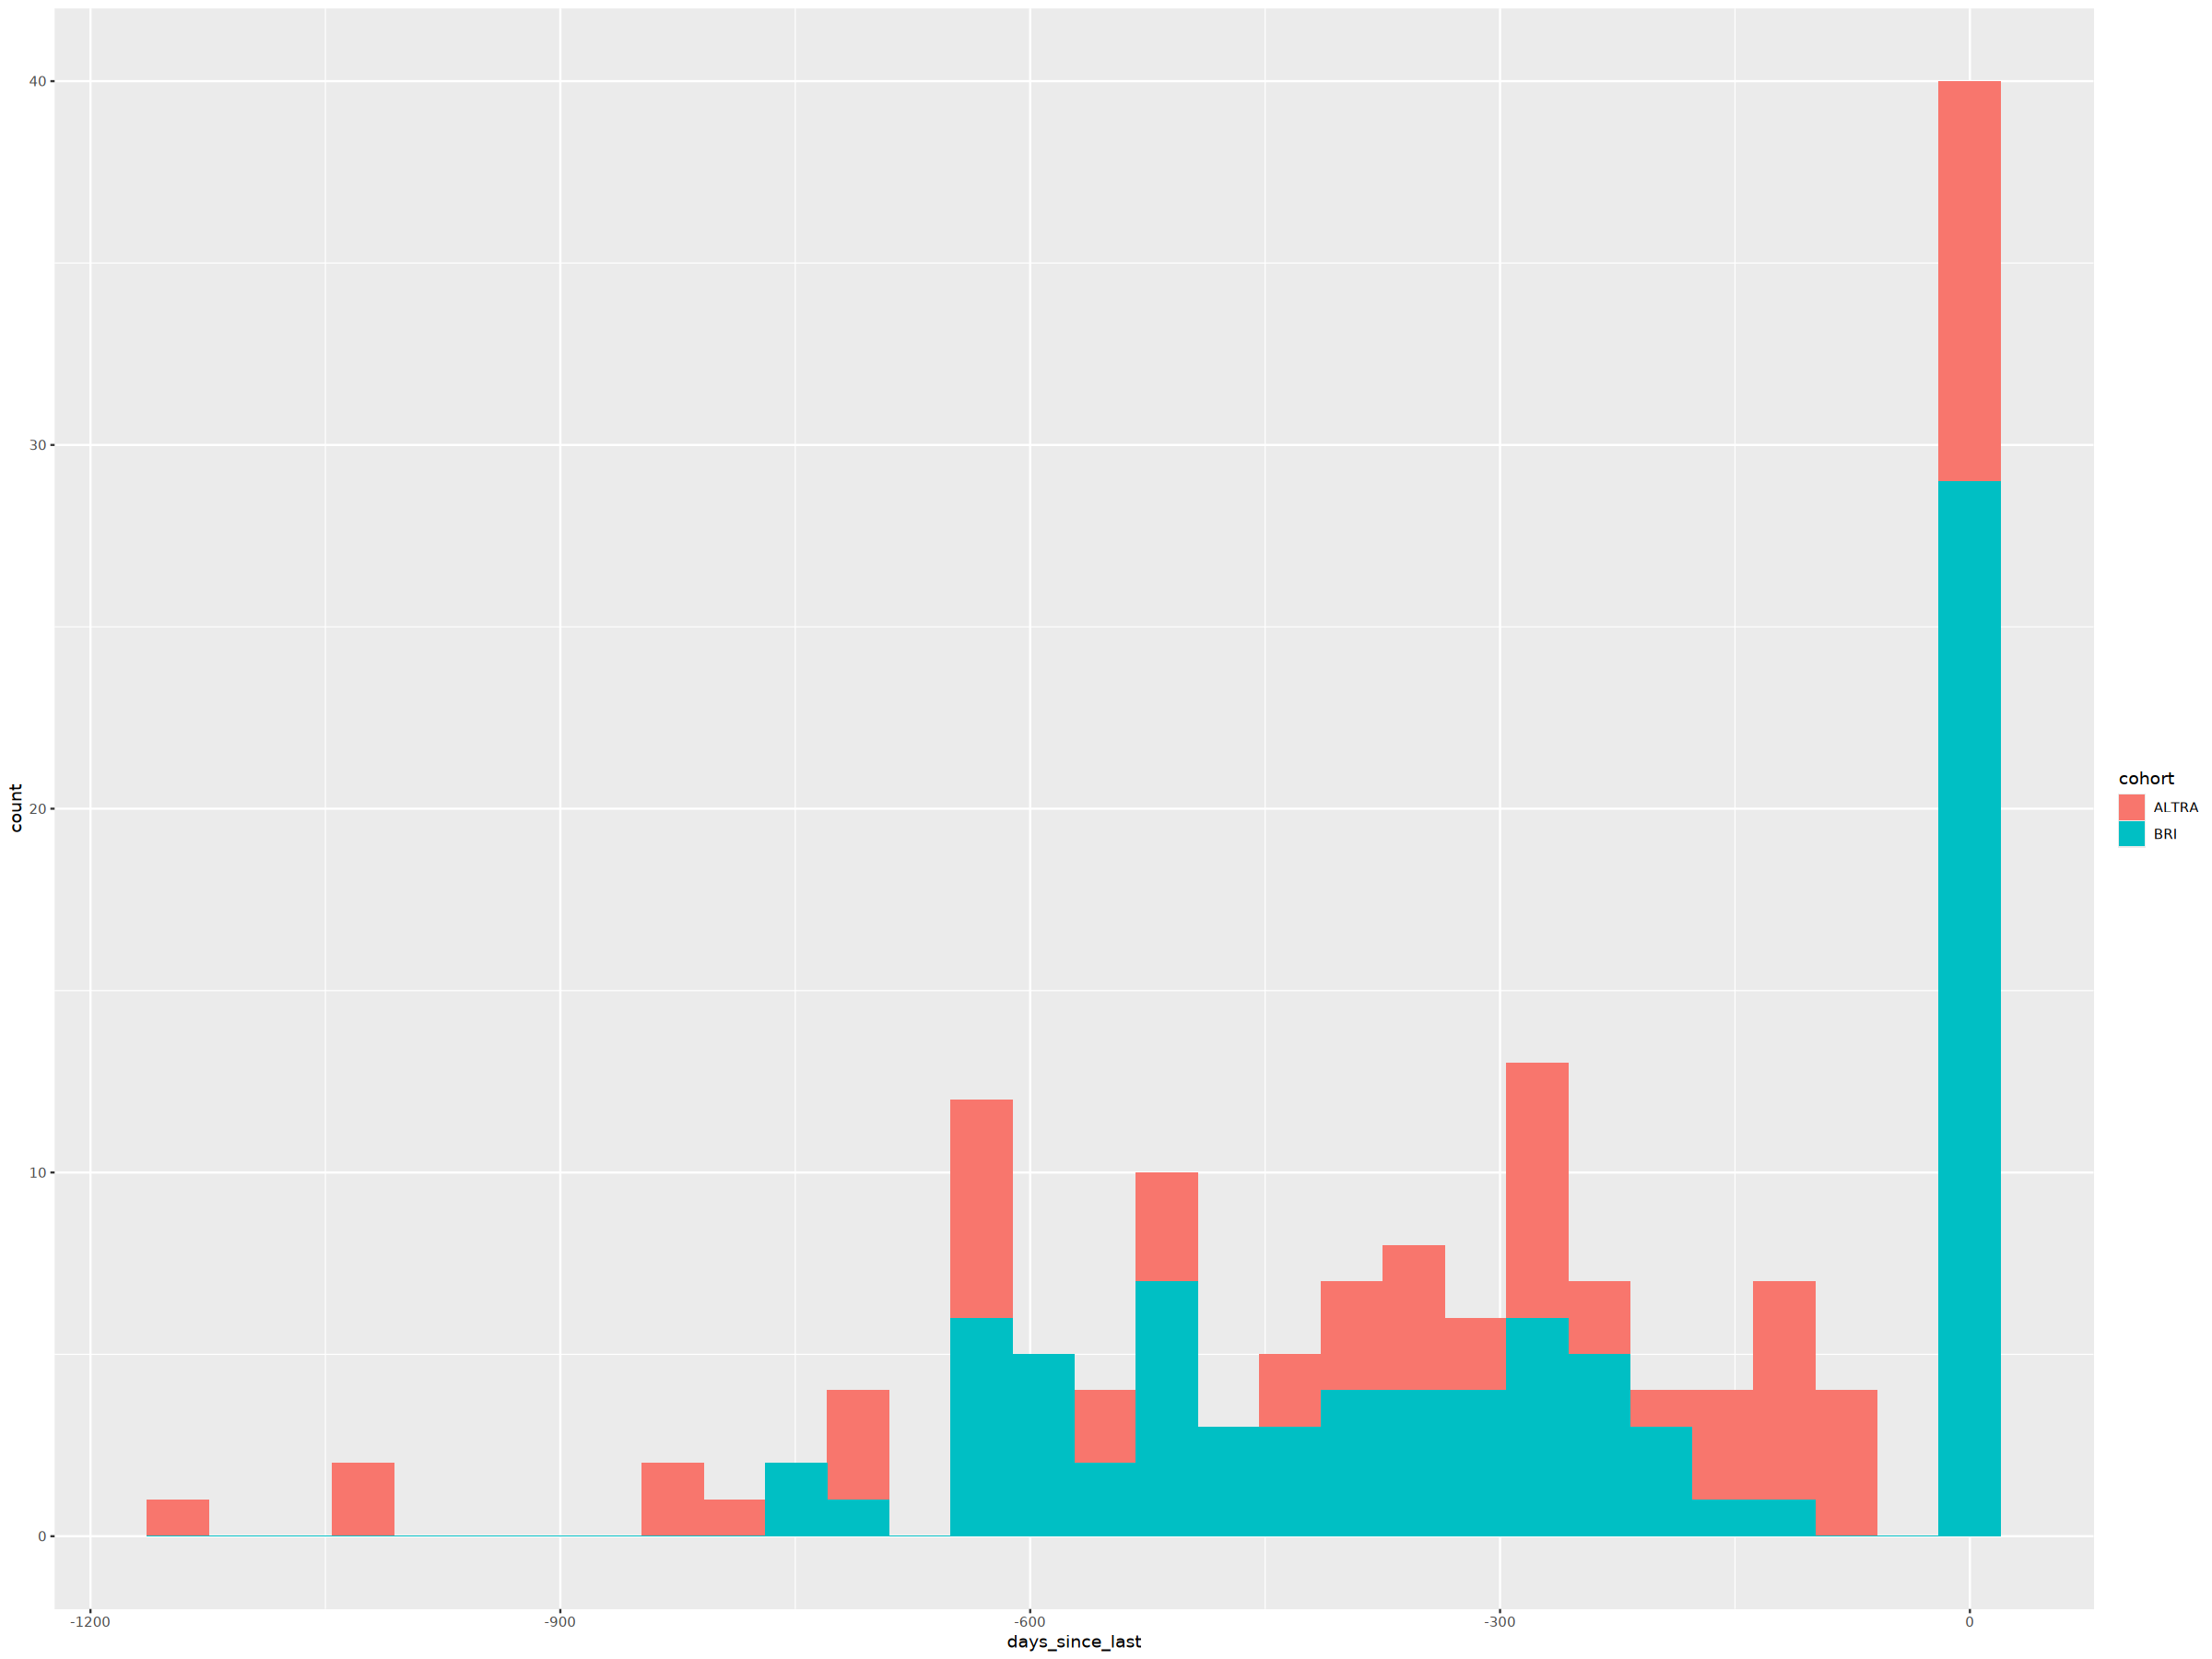

In [41]:
colData(comb_se[['Naive CD4 T cell']])%>%as_tibble()%>%
    ggplot(aes(x=days_since_last, fill=cohort)) +
    geom_histogram()

In [42]:
comb_se%>%saveRDS(file.path(output_path,  'ALTRA_BRI_longitudinal_psedobulk_object_list_090324.rds'))

# make psudobulk object for ALTRA longitduinal and BRI for all cell types combined for variablility test

In [46]:
# load data for one cell type and comebine

CreateSEAll <- function(altra_count_path, altra_meta_path, bri_count_path, bri_meta_path){
    altra_counts <- fread(altra_count_path)%>% 
        rename('V1'='index')%>%mutate(index=as.character(index))
    
    # load the metadata
    altra_meta <- fread(altra_meta_path)%>% rename('V1'='index')%>%
        mutate(index=as.character(index), 
               sample.drawDate=as.character(sample.drawDate),
                BMI=as.character(BMI),
                   cohort='ALTRA')
    # check the index 
    stopifnot(all(altra_counts$index==altra_meta$index))
    
    # load data for one cell type in bri
    bri_counts <- fread(bri_count_path)%>% 
        rename('V1'='index')
    
    # load the metadata
    bri_meta <- fread(bri_meta_path)%>% rename('V1'='index')%>%
        mutate(#sample.diseaseStatesRecordedAtVisit=as.character(sample.diseaseStatesRecordedAtVisit), 
                sample.drawDate=as.character(sample.drawDate),
               BMI=as.character(BMI),
                   cohort='BRI')
    # add last BMI and age for BRI
    bri_meta_age_bmi <- bri_meta%>% 
        group_by(subject.subjectGuid)%>%slice_max(order_by = sample.daysSinceFirstVisit)%>%
        mutate(age_last=age, bmi_last = BMI)%>%select(subject.subjectGuid, age_last, bmi_last, 
                                                      sample.daysSinceFirstVisit)%>%
        rename('sample.daysSinceFirstVisit'='last_visit_day')%>%distinct(.keep_all = TRUE)
    #return(bri_meta_age_bmi)
    bri_meta<- bri_meta%>%left_join(bri_meta_age_bmi, by='subject.subjectGuid',
                                       relationship = "many-to-one")%>%
        mutate(days_since_last=sample.daysSinceFirstVisit-last_visit_day)
    
    # check the index 
    stopifnot(all(bri_counts$index==bri_meta$index))
    # combine the count table
    comb_meta <- bind_rows(altra_meta, bri_meta)%>%
        mutate(cell_type = AIFI_L2,
               bmi_conv_cat = cut(bmi_conv,
                                  breaks = c(0, 25, 30, +Inf), 
                                           labels = c('<25-BMI', '>25-30BMI', '>30BMI')), 
                       bmi_last=coalesce(bmi_last, bmi_conv_cat),
               age_last = coalesce(age_last, age_conv),
              days_since_last=coalesce(days_since_last,days_to_conversion))
    # take the overlap genes
    overlap_genes = intersect(colnames(altra_counts), colnames(bri_counts))
    # combine the count table
    comb_counts <- bind_rows(select(altra_counts, all_of(overlap_genes)), 
                             select(bri_counts, all_of(overlap_genes)))
    
    # check the index of combined object
    stopifnot(all(comb_counts$index==comb_meta$index))
    
    # make count matrix
    counts_mx <- comb_counts %>% select(-index)%>%
        as.data.frame()%>% t()
    # make summarized experiment
    pb_se <- SummarizedExperiment(assays=list(counts=counts_mx), colData=comb_meta)
    
    colnames(pb_se) = colData(pb_se)$sample.sampleKitGuid    
    return(pb_se)
}

In [49]:
altra_count_path = '/home/jupyter/data/ra_longitudinal/scrna/certPro/counts/aifi_l2/ALTRA_scRNA_AIFI_L2_certpro_pseudobulk_aim3_psbulk_counts.tsv'
altra_meta_path = '/home/jupyter/data/ra_longitudinal/scrna/certPro/counts/aifi_l2/ALTRA_scRNA_AIFI_L2_certpro_pseudobulk_aim3_psbulk_metadata.csv'
bri_count_path = '/home/jupyter/data/immune_health/output_results/BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__counts.tsv'
bri_meta_path = '/home/jupyter/data/immune_health/output_results/BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__metadata.csv'

l2_se <- CreateSEAll(altra_count_path, altra_meta_path, bri_count_path, bri_meta_path)

In [51]:
colData(l2_se)%>%as_tibble()%>%colnames()

[1] "index"                               "batch_id"                           
 [3] "hto_barcode"                         "hto_category"                       
 [5] "pbmc_sample_id"                      "pool_id"                            
 [7] "sample.sampleKitGuid"                "cohort.cohortGuid"                  
 [9] "subject.subjectGuid"                 "subject.biologicalSex"              
[11] "subject.race"                        "subject.ethnicity"                  
[13] "subject.birthYear"                   "sample.visitName"                   
[15] "sample.drawDate"                     "sample.diseaseStatesRecordedAtVisit"
[17] "sample.daysSinceFirstVisit"          "file.id"                            
[19] "subset_grp"                          "predicted_doublet"                  
[21] "AIFI_L2"                             "doublets_manual"                    
[23] "Status_Xsec"                         "Status_Long"                        
[25] "anti_ccp3_finalCombined"             "days_to_conversion"                 
[27] "BMI"                                 "CMV_Status_Subj"                    
[29] "age_conv"                            "bmi_conv"                           
[31] "file.batchID"                        "status"                             
[33] "psbulk_n_cells"                      "psbulk_counts"                      
[35] "cohort"                              "AIFI_L1"                            
[37] "subject.cmv"                         "subject.ageAtFirstDraw"             
[39] "sample.subjectAgeAtDraw"             "specimen.specimenGuid"              
[41] "pipeline.fileGuid"                   "age"                                
[43] "days_since_first"                    "lib_size"                           
[45] "log_lib_size"                        "age_last"                           
[47] "bmi_last"                            "last_visit_day"                     
[49] "days_since_last"                     "cell_type"                          
[51] "bmi_conv_cat"

In [53]:
colData(l2_se)%>%as_tibble()%>%filter(cell_type=='CD14 monocyte')%>%group_by(cohort)%>%tally()

cohort,n
<chr>,<int>
ALTRA,65
BRI,86


In [54]:
l2_se%>%saveRDS(file.path(output_path,  'ALTRA_BRI_longitudinal_l2_psedobulk_object_090324.rds'))